# Arctic-EDS Data Preparation - Mean Annual Snowfall

## Objectives
This notebook will execute the necessary preprocessing of data prior to being ingested into Rasdaman. The scope of this notebook will cover one "plate" in the original Environmental Atlas of Alaska.

### Plate
#### Mean Annual Snowfall
![mean_annual_snowfall.png](attachment:mean_annual_snowfall.png)

To create a modern version of this plate, we will want one coverage in Rasdaman for the mean annual snowfall.

## Replacement Data
There are two datasets that we'll pull from to revamp this plate.

### Historical 
 - CKAN entry: [Historical Decadal Averages of Monthly Snowfall Equivalent 771m CRU TS3.0/TS3.1](http://ckan.snap.uaf.edu/dataset/historical-decadal-averages-of-monthly-snowfall-equivalent-771m-cru-ts3-0-ts3-1)
 - This dataset has decadal snow water equivalent products downscaled from CRU TS data via the delta method.
 - 771 m spatial resolution.
 - CRU TS version 3.1. These are essentially interpolated observations.
 - Range: 1901 - 2009
 
### Projected
 - CKAN entry: [Projected Decadal Averages of Monthly Snowfall Equivalent 771m CMIP5/AR5](http://ckan.snap.uaf.edu/dataset/projected-decadal-averages-of-monthly-snowfall-equivalent-771m-cmip5-ar5)
 - This dataset has projected decadal snow water equivalent products from various CMIP5/AR5 situations.
 - 2 km spatial resolution
 - Scenarios: RCP 4.5, RCP 6.0, RCP 8.5
 - Models: GFDL-CM3, NCAR-CCSM4, GISS-E2-R, MRI-CGCM3, IPSL-CM5A-LR, 5-Model Average
 - Range: 2010 - 2100
 - Downscaling: Delta with a PRISM 1961 - 1990 baseline.
 
### Structure
Once unzipped, this dataset consists of GeoTIFFs where each file is a single month of a single decade for a single model/scenario (or historical) combination.

We'll want a coverage in Rasdaman with the following axes (besides x and y):
 - decade
 - Model
 - Scenario

## Processing

The only true processing step needed is to summarize the monthly data to an annual time step by taking the sum of the monthly mean values for each decade. Processing here done from an *Atlas* compute node.

### Historical

```sh
cd $YOUR_SCRATCH_DIRECTORY

cp /workspace/CKAN/CKAN_Data/Base/AK_771m/historical/CRU_TS/SWE/swe_decadal_mean_monthly_total_mm_cru_TS31.zip .
# extract
unzip swe_decadal_mean_monthly_total_mm_cru_TS31.zip
```

The plan of attack will be to iterate over decades, read in the 12 monthly data files for a single decade, and compute the totals and write the new files.

First handle the imports and define some functions to be used for the reading and summarization:

In [35]:
import warnings
from multiprocessing import Pool
from pathlib import Path
import numpy as np
import rasterio as rio
from tqdm import tqdm


def read_tif(fp):
    with rio.open(fp) as src:
        arr = src.read(1)
    arr[np.isclose(arr, src.meta["nodata"])] = np.nan
    
    return arr


def summarize_decade(args):
    fps, profile, out_fp = args
    arr = np.array([read_tif(fp) for fp in fps])
    mean_arr = np.round(arr.sum(axis=0) * 0.0393701)
    mean_arr[np.isnan(mean_arr)] = profile["nodata"]
    
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(mean_arr, 1)

    return

Then, supply the path to where the data were unzipped, manage the paths in play and get the needed profile information for writing new rasters with `rasterio`:

In [46]:
scratch_dir = "/atlas_scratch/kmredilla/arctic_eds"


scratch_dir = Path(scratch_dir)
out_dir = scratch_dir.joinpath("mean_annual_snowfall")
out_dir.mkdir(exist_ok=True)

# get a GeoTIFF rasterio profile to use for writing
tmp_fp = list(scratch_dir.glob(f"swe_decadal_mean_monthly_total_mm_cru_TS31/*.tif"))[0]
with rio.open(tmp_fp) as src:
    profile = src.profile
    
profile.update({
    "dtype": "int16",
    "nodata": -9999,
})

Note, the data files are already clipped to the AK boundary:

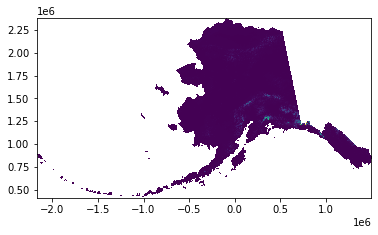

In [21]:
from rasterio.plot import show

with rio.open(tmp_fp) as src:
    show(src, interpolation="none")

Finally, execute the `summarize_decade` function for all (10) decades:

In [55]:
# maximum on Atlas viz nodes
ncores = 10


args = [
    (
        list(scratch_dir.glob(f"swe_decadal_mean_monthly_total_mm_cru_TS31/*{year}_{year + 9}.tif")),
        profile,
        out_dir.joinpath(f"swe_CRU-TS_historical_{year}-{year + 9}.tif"),
    ) 
    for year in np.arange(1910, 2001, 10)
]
   
with Pool(ncores) as pool:
    _ = [
        result for result in tqdm(
            pool.imap_unordered(summarize_decade, args), 
            total=len(args),
            desc=f"Summarizing CRU-TS",
        )
    ]

Summarizing CRU-TS: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


### Projected

Copy the `.zip`s and extract

```sh
cp /workspace/CKAN/CKAN_Data/Base/AK_771m/projected/AR5_CMIP5_models/SWE/swe*.zip .
# extract files and arrange to have a flat structure
mkdir swe_decadal_mean_monthly_total_mm_ar5
unzip 'swe*.zip' -d swe_decadal_mean_monthly_total_mm_ar5
mv swe_decadal_mean_monthly_total_mm_ar5/*/*/*.tif swe_decadal_mean_monthly_total_mm_ar5
# will just leave the empty directories
```

Do the same as was done for the historical, but iterate over model and scenario in addition to just the decade.

In [56]:
ncores = 9


from itertools import product


models = ['GFDL-CM3', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MRI-CGCM3', 'NCAR-CCSM4']
scenarios = ["rcp45", "rcp60", "rcp85"]

for model, scenario in product(models, scenarios):
    
    # snippet to handle NCAR-CCSM4 files named as 
    #  "_CCSM4_" instead of "_NCAR-CCSM4_" (annoying!!)
    out_model = model
    if model == "NCAR-CCSM4":
        model = "CCSM4"
    
    args = [
        (
            list(scratch_dir.glob(f"swe_decadal_mean_monthly_total_mm_ar5/*{model}*{scenario}*{year}_{year + 9}.tif")),
            profile,
            out_dir.joinpath(f"swe_{out_model}_{scenario}_{year}-{year + 9}.tif"),
        ) 
        for year in np.arange(2010, 2091, 10)
    ]

    with Pool(ncores) as pool:
        _ = [
            result for result in tqdm(
                pool.imap_unordered(summarize_decade, args), 
                total=len(args),
                desc=f"Summarizing {out_model}, {scenario}",
            )
        ]

Summarizing NCAR-CCSM4, rcp85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.34it/s]


## Quality

Verify that we have the expected number of new tifs, and they have approximately the same file sizes. Expected number would be $9 * 5 * 3$ (projected) $+  10$ (historical) $=145$.

In [57]:
out_fps = sorted(list(out_dir.glob("*.tif")))
print(f"Number of files: {len(out_fps)}")

sizes = [round(fp.stat().st_size / 1e6, 1) for fp in out_fps]
print(f"Unique file sizes (MB): {np.unique(sizes, return_counts=True)}")

Number of files: 145
Unique file sizes (MB): (array([1.8, 1.9, 2. , 2.1]), array([ 3, 31, 98, 13]))


Plot some of the new rasters:

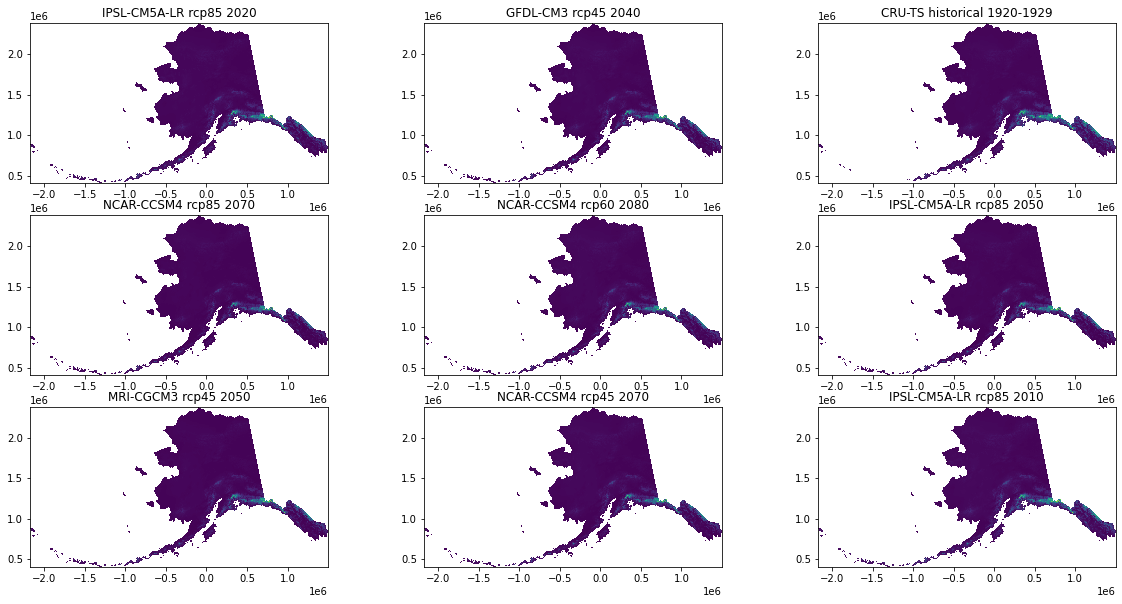

In [52]:
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, axs = plt.subplots(3, 3, figsize=(20, 10))

arrs = []
titles = []
for ax in axs.flatten():
    i = np.random.randint(len(out_fps))
    fp = out_fps[i]
    with rio.open(fp) as src:
        show(src, ax=ax, interpolation="none")
        arrs.append(src.read(1))
    title = " ".join(fp.name.split(".")[0].split("_")[1:])
    ax.set_title(title)
    titles.append(title)

plt.show()

And look at some histograms:

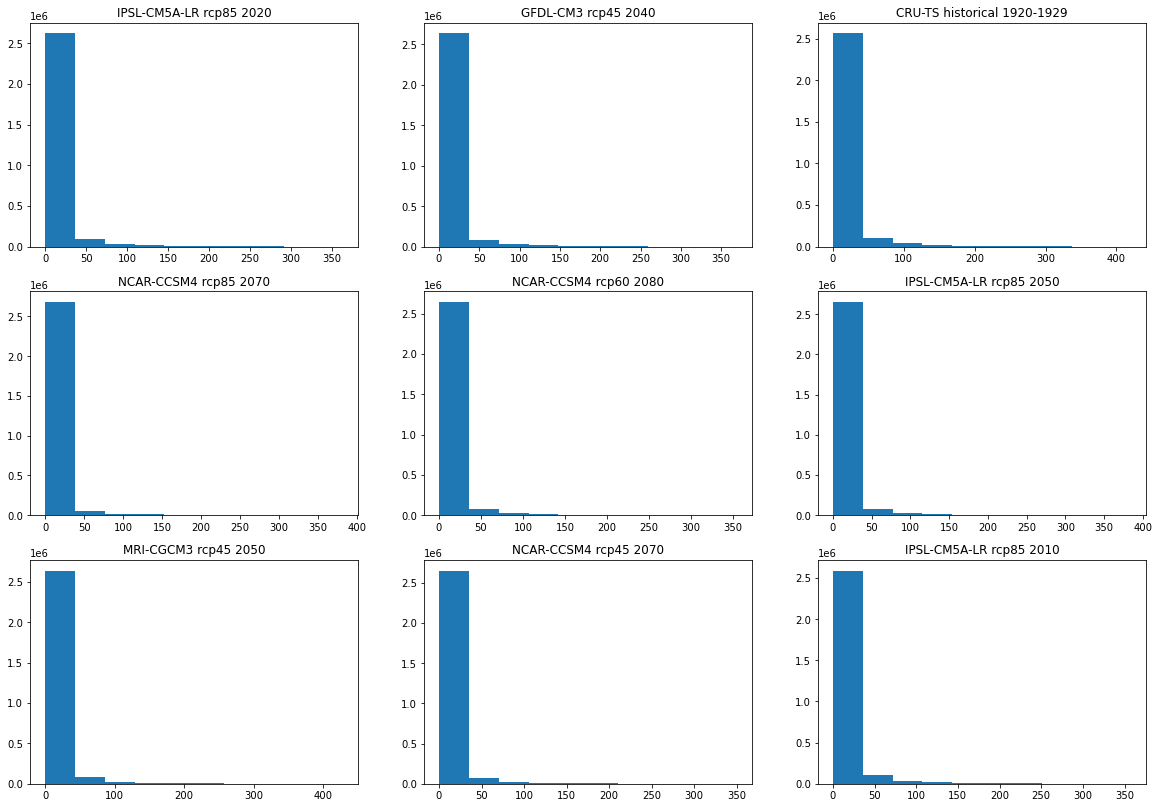

In [53]:
fig, axs = plt.subplots(3, 3, figsize=(20, 14))
for ax, arr, title in zip(axs.flatten(), arrs, titles):
    arr = arr.flatten()
    arr = arr[arr != -9999]
    ax.hist(arr)
    ax.set_title(title)

plt.show()

OK at this point these data are basically ready for ingest!
The data now need to be moved to a Rasdaman server (Apollo, Zeus).


```sh
scp -r /atlas_scratch/kmredilla/arctic_eds/mean_annual_snowfall kmredilla@apollo.snap.uaf.edu:
```

These directories are now in your home directory on Apollo.